In [32]:
import numpy as np
import matplotlib.pyplot as plt


In [33]:
df = pd.read_csv('iphone_data.csv')
display(df);

,Model,battery_mah,ram,storage,lunch_year,used_month,battery_health,price
0,iPhone SE (1st gen),1624,2,16,2016,116,52,1425
1,iPhone 15 Pro Max,4422,8,256,2023,26,55,66177
2,iPhone 15 Plus,4395,6,128,2023,26,81,74219
3,iPhone 13 Pro Max,4352,6,128,2021,50,61,38435
4,iPhone 8,1821,2,64,2017,98,85,11418
...,...,...,...,...,...,...,...,...
1995,iPhone 8,1821,2,64,2017,98,88,13717
1996,iPhone 12 Pro,2815,6,128,2020,61,73,28545
1997,iPhone 15,3349,6,128,2023,26,63,47245
1998,iPhone 12 Pro,2815,6,128,2020,61,95,45201


In [34]:
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle

In [35]:
print("\n--- Dataframe info ---")
print(df.info())


--- Dataframe info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Model           2000 non-null   object
 1   battery_mah     2000 non-null   int64 
 2   ram             2000 non-null   int64 
 3   storage         2000 non-null   int64 
 4   lunch_year      2000 non-null   int64 
 5   used_month      2000 non-null   int64 
 6   battery_health  2000 non-null   int64 
 7   price           2000 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 125.1+ KB
None


In [36]:
print("\n--- Numeric summary ---")
print(df.describe().T)


--- Numeric summary ---
                 count        mean           std     min      25%      50%  \
battery_mah     2000.0   3062.7440    906.610303  1440.0  2658.00   3095.0   
ram             2000.0      4.5190      2.247257     1.0     3.00      4.0   
storage         2000.0     91.5440     60.136380     8.0    64.00     64.0   
lunch_year      2000.0   2019.3640      3.406216  2012.0  2017.00   2020.0   
used_month      2000.0     69.5345     41.028898    14.0    38.00     61.0   
battery_health  2000.0     76.0780     14.409779    50.0    63.00     77.0   
price           2000.0  37629.7965  32369.365309  1343.0  4630.25  33168.5   

                    75%       max  
battery_mah      3582.0    4685.0  
ram                 6.0       8.0  
storage           128.0     256.0  
lunch_year       2022.0    2024.0  
used_month         98.0     158.0  
battery_health     89.0     100.0  
price           60349.5  151935.0  


In [37]:
print("\n--- Missing values ---")
print(df.isnull().sum().sort_values(ascending=False).head(20))


--- Missing values ---
Model             0
battery_mah       0
ram               0
storage           0
lunch_year        0
used_month        0
battery_health    0
price             0
dtype: int64


In [38]:
# Auto-detect target column (prefer 'price')
target_candidates = [c for c in df.columns if "price" in c.lower()]
if len(target_candidates) > 0:
    target = target_candidates[0]
else:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) == 0:
        raise ValueError("No numeric columns found to use as target.")
    target = numeric_cols[-1]
print("\nUsing target:", target)



Using target: price


In [39]:
# Separate features and target
X = df.drop(columns=[target]).copy()
y = df[target].copy()

In [40]:
# Convert bools to int
for c in X.columns:
    if X[c].dtype == bool:
        X[c] = X[c].astype(int)

In [41]:
# Identify numeric and categorical feature lists
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print("\nNumeric features:", numeric_cols)
print("Categorical features:", cat_cols)


Numeric features: ['battery_mah', 'ram', 'storage', 'lunch_year', 'used_month', 'battery_health']
Categorical features: ['Model']


In [42]:
# Fill numeric missing with median; categorical missing with mode
for c in numeric_cols:
    if X[c].isnull().any():
        median = X[c].median()
        X[c] = X[c].fillna(median)
        print(f"Filled numeric {c} missing with median={median}")

for c in cat_cols:
    if X[c].isnull().any():
        mode_val = X[c].mode().iloc[0] if not X[c].mode().empty else ""
        X[c] = X[c].fillna(mode_val)
        print(f"Filled categorical {c} missing with mode='{mode_val}'")

In [43]:
# Drop rows with missing target
if y.isnull().any():
    n_before = len(y)
    mask = ~y.isnull()
    X = X.loc[mask].reset_index(drop=True)
    y = y.loc[mask].reset_index(drop=True)
    print(f"Dropped {n_before-len(y)} rows with missing target")

In [44]:
# STEP 4: Encoding (one-hot) and correlation
# -----------------------
X_encoded = pd.get_dummies(X, drop_first=True)
print("\nAfter one-hot, shape:", X_encoded.shape)


After one-hot, shape: (2000, 44)


In [45]:
# Correlation with target (only numeric)
combined = pd.concat([X_encoded, y.reset_index(drop=True)], axis=1)
corr = combined.corr()
if pd.api.types.is_numeric_dtype(y):
    target_corr = corr[target].sort_values(ascending=False)
    print("\nTop positive correlations with target:\n", target_corr.head(8))
    print("\nTop negative correlations with target:\n", target_corr.tail(8))


Top positive correlations with target:
 price                      1.000000
ram                        0.897400
lunch_year                 0.870652
storage                    0.857469
battery_mah                0.770716
Model_iPhone 16 Pro Max    0.363629
Model_iPhone 15 Pro Max    0.288027
Model_iPhone 16 Pro        0.267442
Name: price, dtype: float64

Top negative correlations with target:
 Model_iPhone 5s             -0.161092
Model_iPhone 5c             -0.161125
Model_iPhone 7              -0.161625
Model_iPhone SE (1st gen)   -0.165459
Model_iPhone 6s Plus        -0.173605
Model_iPhone 7 Plus         -0.177750
Model_iPhone 6s             -0.186064
used_month                  -0.870062
Name: price, dtype: float64


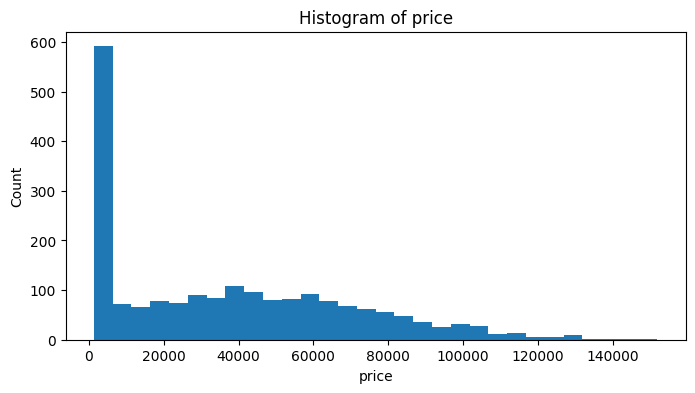

In [46]:
# STEP 5: Visualizations
# -----------------------
# 5.1 Histogram of target
if pd.api.types.is_numeric_dtype(y):
    plt.figure(figsize=(8,4))
    plt.hist(y.dropna(), bins=30)
    plt.title(f"Histogram of {target}")
    plt.xlabel(target)
    plt.ylabel("Count")
    plt.show()

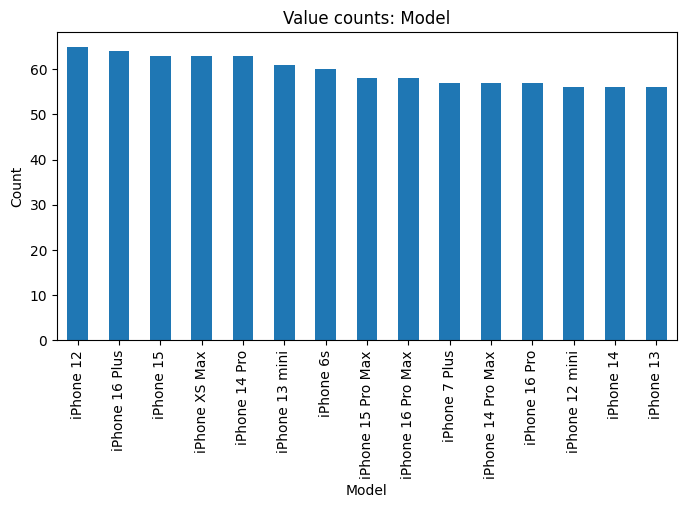

In [47]:
# 5.2 Bar chart for first categorical (if exists)
if len(cat_cols) > 0:
    top_cat = cat_cols[0]
    plt.figure(figsize=(8,4))
    X[top_cat].value_counts().head(15).plot(kind='bar')
    plt.title(f"Value counts: {top_cat}")
    plt.xlabel(top_cat)
    plt.ylabel("Count")
    plt.show()

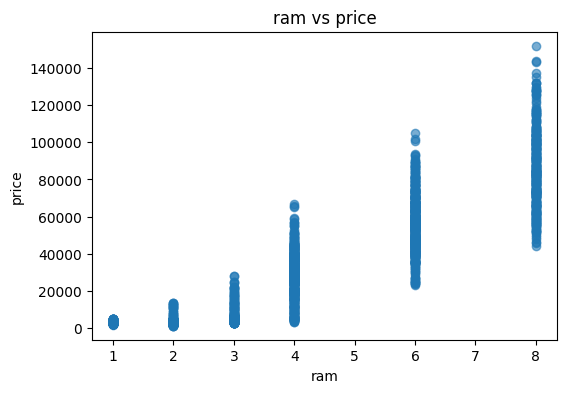

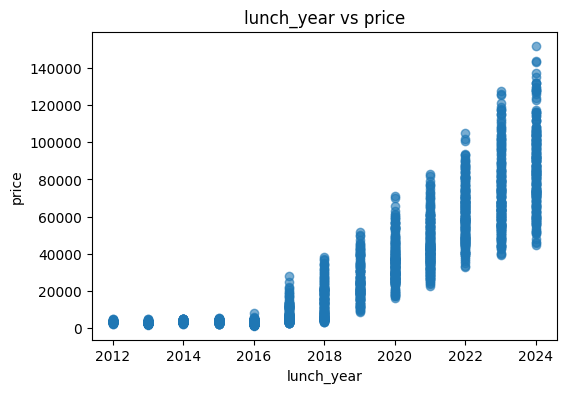

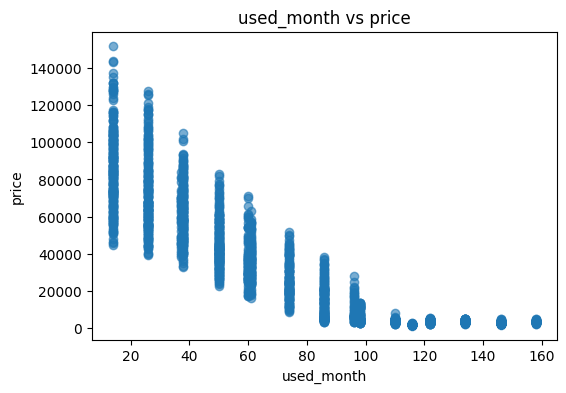

In [48]:
# 5.3 Scatter top 3 features (by abs correlation) vs target
if pd.api.types.is_numeric_dtype(y):
    corr_with_target = target_corr.drop(labels=[target], errors='ignore').abs().sort_values(ascending=False)
    top_feats = corr_with_target.index.tolist()[:3]
    for feat in top_feats:
        plt.figure(figsize=(6,4))
        plt.scatter(X_encoded[feat], y, alpha=0.6)
        plt.title(f"{feat} vs {target}")
        plt.xlabel(feat)
        plt.ylabel(target)
        plt.show()

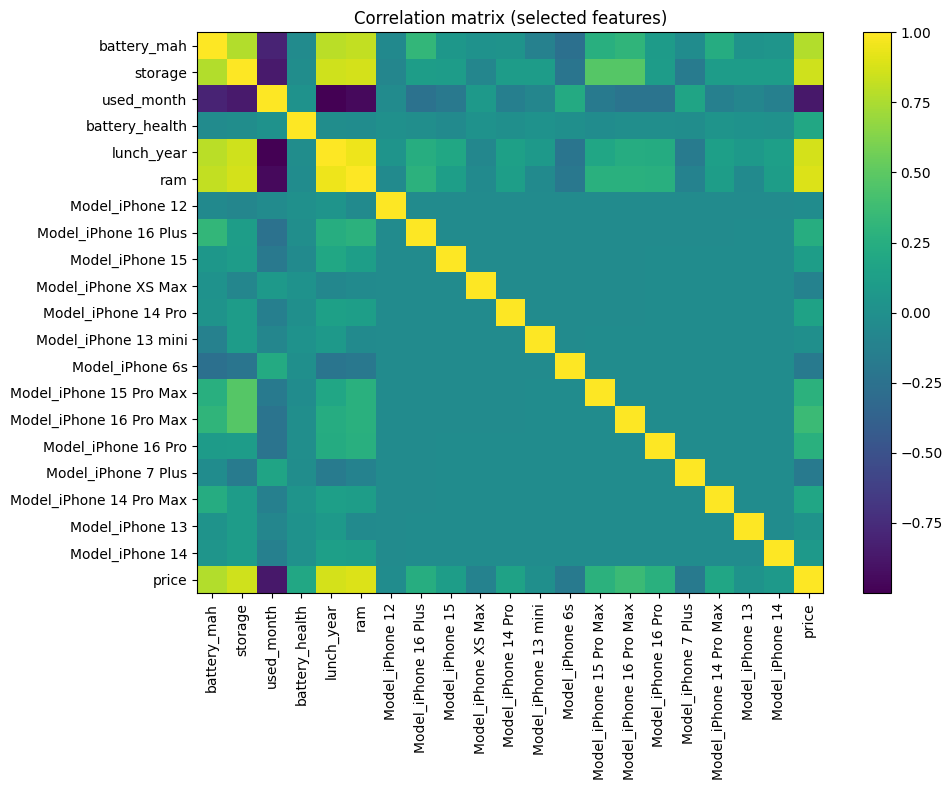

In [49]:
# 5.4 Correlation matrix (selected)
plt.figure(figsize=(10,8))
top_for_heat = X_encoded.var().sort_values(ascending=False).index.tolist()[:20]
heat_df = pd.concat([X_encoded[top_for_heat], y.reset_index(drop=True)], axis=1)
heat_corr = heat_df.corr()
plt.imshow(heat_corr, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(heat_corr.columns)), heat_corr.columns, rotation=90)
plt.yticks(range(len(heat_corr.index)), heat_corr.index)
plt.title("Correlation matrix (selected features)")
plt.tight_layout()
plt.show()


In [50]:
# STEP 6: Train Linear Regression
# -----------------------
# Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model metrics on test set ---")
print("RMSE:", rmse)
print("MAE: ", mae)
print("R^2: ", r2)



--- Model metrics on test set ---
RMSE: 8036.981812014701
MAE:  6171.673974608221
R^2:  0.9449504260452639


In [51]:
# STEP 7: Derive equation in original units
# -----------------------
lr = pipeline.named_steps["lr"]
scaler = pipeline.named_steps["scaler"]

In [52]:
# Coefficients in scaled space
coefs_scaled = lr.coef_.ravel() if hasattr(lr.coef_, "ravel") else np.array([lr.coef_])
feature_names = X_encoded.columns.tolist()
means = scaler.mean_
scales = scaler.scale_

In [53]:
 # Transform back to original-space coefficients:
# coef_original_i = coef_scaled_i / scale_i
# intercept_original = intercept_scaled - sum(coef_scaled_i * mean_i / scale_i)
coef_original = coefs_scaled / scales
intercept_original = lr.intercept_ - np.dot(coefs_scaled, means / scales)

In [54]:
# Print top coefficients
print("\nIntercept (original units):", intercept_original)
abs_order = np.argsort(np.abs(coef_original))[::-1]
print("\nTop 10 features by absolute coefficient magnitude:")
for idx in abs_order[:10]:
    print(f"  {feature_names[idx]} : {coef_original[idx]}")


Intercept (original units): -4.6492997116512215e+19

Top 10 features by absolute coefficient magnitude:
  Model_iPhone 5 : 3.793785300084117e+17
  Model_iPhone 16 Pro Max : -3.453158381245955e+17
  Model_iPhone 5c : 3.294266104721565e+17
  Model_iPhone 5s : 3.1531268238201504e+17
  Model_iPhone 15 Plus : -2.71066494269098e+17
  Model_iPhone 6s : 2.6681097327978208e+17
  Model_iPhone 15 Pro Max : -2.6537941673754432e+17
  Model_iPhone SE (1st gen) : 2.4001256775198474e+17
  Model_iPhone 6 : 2.3681904042773837e+17
  Model_iPhone 14 Plus : -2.1485813531962982e+17


In [55]:
# Build a readable equation string (may be long)
terms = [f"({coef_original[i]:.6g})*{feature_names[i]}" for i in range(len(feature_names))]
equation = f"{target} = {intercept_original:.6g} + " + " + ".join(terms)
print("\nEquation (truncated):")
print(equation[:2000] + (" ... (truncated)" if len(equation) > 2000 else ""))


Equation (truncated):
price = -4.6493e+19 + (1.10983e+14)*battery_mah + (-7.01964e+16)*ram + (1.02898e+15)*storage + (2.30478e+16)*lunch_year + (-2.30834e+15)*used_month + (511.884)*battery_health + (7.10291e+15)*Model_iPhone 11 Pro + (-9.53344e+16)*Model_iPhone 11 Pro Max + (-2.03162e+16)*Model_iPhone 12 + (5.4222e+16)*Model_iPhone 12 Pro + (-4.48635e+16)*Model_iPhone 12 Pro Max + (4.26335e+16)*Model_iPhone 12 mini + (-1.80335e+17)*Model_iPhone 13 + (-2.52928e+16)*Model_iPhone 13 Pro + (-1.64798e+17)*Model_iPhone 13 Pro Max + (-9.27698e+16)*Model_iPhone 13 mini + (-9.64615e+16)*Model_iPhone 14 + (-2.14858e+17)*Model_iPhone 14 Plus + (-8.76939e+16)*Model_iPhone 14 Pro + (-2.12328e+17)*Model_iPhone 14 Pro Max + (-1.54978e+17)*Model_iPhone 15 + (-2.71066e+17)*Model_iPhone 15 Plus + (-1.39195e+16)*Model_iPhone 15 Pro + (-2.65379e+17)*Model_iPhone 15 Pro Max + (-8.88617e+16)*Model_iPhone 16 + (-2.12386e+17)*Model_iPhone 16 Plus + (-9.11923e+16)*Model_iPhone 16 Pro + (-3.45316e+17)*Model_i

In [56]:
# -----------------------
# STEP 8: Predict helper
# -----------------------
def predict_price_for_row(raw_row):
    """
    raw_row: dict or pandas Series with same raw feature names as original X (before encoding).
    Returns predicted price (float).
    """
    if isinstance(raw_row, dict):
        row_df = pd.DataFrame([raw_row])
    else:
        row_df = pd.DataFrame([raw_row.to_dict()])

    # Ensure all original columns exist
    for c in X.columns:
        if c not in row_df.columns:
            row_df[c] = np.nan

    # Fill missing same way used in training
    for c in numeric_cols:
        if c in row_df.columns and row_df[c].isnull().any():
            row_df[c] = row_df[c].fillna(X[c].median())
    for c in cat_cols:
        if c in row_df.columns and row_df[c].isnull().any():
            row_df[c] = row_df[c].fillna(X[c].mode().iloc[0] if not X[c].mode().empty else "")

    # One-hot encode and align with training columns
    row_enc = pd.get_dummies(row_df, drop_first=True)
    # Add any missing training columns with 0
    for col in X_encoded.columns:
        if col not in row_enc.columns:
            row_enc[col] = 0
    row_enc = row_enc[X_encoded.columns]
    # Predict
    return float(pipeline.predict(row_enc)[0])

# Example usage of predict helper:
if pd.api.types.is_numeric_dtype(y):
    sample_raw = X.iloc[0].to_dict()
    predicted_sample = predict_price_for_row(sample_raw)
    print("\nExample prediction (first row):", predicted_sample, "actual:", float(y.iloc[0]))


Example prediction (first row): -2.4001256775199155e+17 actual: 1425.0


In [57]:
# STEP 9: Save model + metadata
# -----------------------
model_output = {
    "pipeline": pipeline,
    "feature_columns": X_encoded.columns.tolist(),
    "intercept_original": float(intercept_original),
    "coef_original": dict(zip(feature_names, coef_original.tolist()))
}
with open("SmartResell_Model.pkl", "wb") as f:
    pickle.dump(model_output, f)


In [58]:

files.download('SmartResell_Model.pkl')

NameError: name 'files' is not defined